In [8]:
#import the different packages used throughout
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import math
import datetime

%matplotlib inline

In [3]:
#calcuate the distance (in degrees) between 2 points in lat/long
def lat_long_to_arc(lat1,long1,lat2,long2):
    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    if cos>1: cos=1
    if cos<-1: cos=-1
    arc = math.acos( cos )

    return arc

In [4]:
def find_nearest_box(llat,llon,point):
    D = [lat_long_to_arc(l1,l2,point[0],point[1]) for l1,l2 in zip(llat,llon)]
    return np.argmin(D)
    

In [28]:
def remove_dublicate(Data, Time, labels, month, year):
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    time = pd.DatetimeIndex(Time)
    index = np.argwhere((labels==-1) & (time.month>month))

    Data = np.delete(Data,index,0)
    Time = np.delete(Time,index)
    time = np.delete(time,index)
    labels = np.delete(labels,index)

    for i in range(n_clusters_):
        cluster = Data[labels==i,:]
        tcluster = time[labels==i]
        if month<12:
            if np.amin(np.array(tcluster.month))>month:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]
            elif np.max(tcluster).month>month & np.max(tcluster).day>4:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]
        else:
            if np.amax(np.array(tcluster.month))==1:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]
            elif np.max(tcluster).month==1 & np.max(tcluster).day>4:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]

    return Data, Time, labels

In [25]:
month=1
year = 2000
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
time = pd.DatetimeIndex(Time)
index = np.argwhere((labels==-1) & (time.month>month))

Data = np.delete(Data,index,0)
Time = np.delete(Time,index)
time = np.delete(time,index)
labels = np.delete(labels,index)

for i in range(n_clusters_):
    cluster = Data[labels==i,:]
    tcluster = time[labels==i]
    print(np.max(tcluster).month)
    if np.amin(np.array(tcluster.month))>month:
        print(i)
        Data = Data[labels!=i,:]
        Time = Time[labels!=i]
        time = time[labels!=i]
        labels = labels[labels!=i]
    elif np.max(tcluster).month>month & np.max(tcluster).day>4:
        Data = Data[labels!=i,:]
        Time = Time[labels!=i]
        time = time[labels!=i]
        labels = labels[labels!=i]
        

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


(119574, 23) (119574,)


(166552, 23)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

Text(0.5, 1.0, 'Range of Latent Heat Profiles in Events')

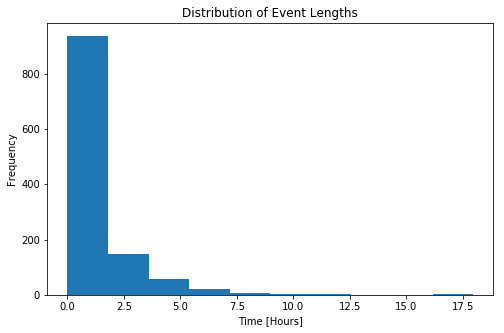

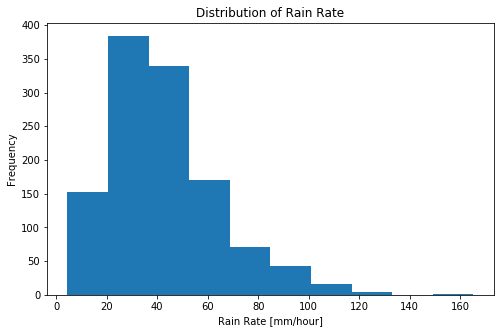

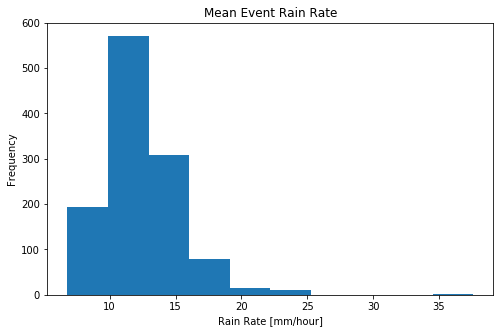

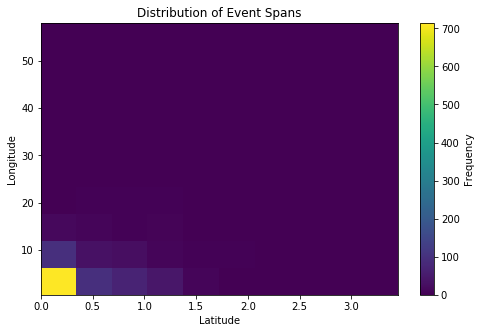

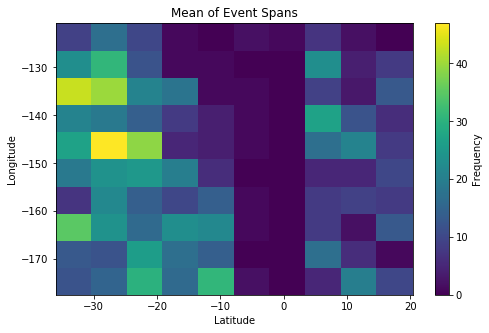

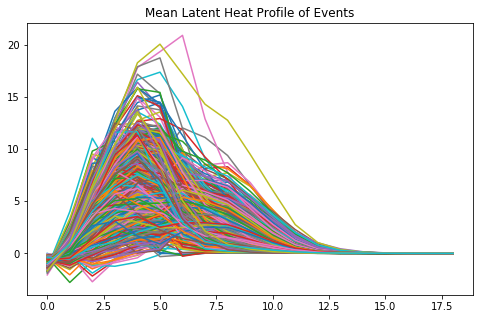

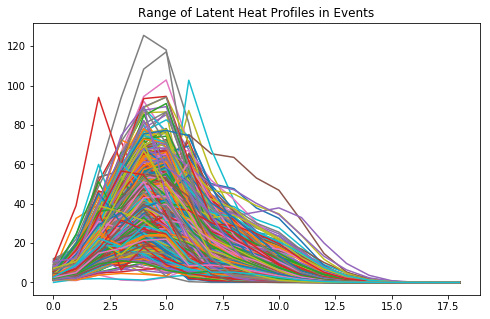

In [29]:
file = xr.open_dataset('/Users/lauren/Downloads/2000_01Clusted_Data.nc4')
Data = file.Data.data #[delta_time, lat, lon, surface_rain, latent heat profile]
labels = file.Labels.data
Time = file.time.data

Data, Time, labels = remove_dublicate(Data, Time, labels, 1, 2000)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
cluster_spans = np.zeros((len(Data[0,:]),n_clusters_))
cluster_means = np.zeros((len(Data[0,:]),n_clusters_))
for i in range(n_clusters_):
    cluster = Data[labels==i,:]
    cluster_spans[:,i] = np.amax(cluster,axis=0)-np.amin(cluster,axis=0)
    cluster_means[:,i] = np.nanmean(cluster,axis=0)

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_spans[0,:])
plt.title('Distribution of Event Lengths')
plt.xlabel('Time [Hours]')
plt.ylabel('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_spans[3,:])
plt.title('Distribution of Rain Rate')
plt.xlabel('Rain Rate [mm/hour]')
plt.ylabel('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_means[3,:])
plt.title('Mean Event Rain Rate')
plt.xlabel('Rain Rate [mm/hour]')
plt.ylabel('Frequency')


fig = plt.figure(figsize=(8,5))
plt.hist2d(cluster_spans[1,:],cluster_spans[2,:])
plt.title('Distribution of Event Spans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar().set_label('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist2d(cluster_means[1,:],cluster_means[2,:])
plt.title('Mean of Event Spans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar().set_label('Frequency')

fig = plt.figure(figsize=(8,5))
plt.plot(cluster_means[4:,:]);
plt.title('Mean Latent Heat Profile of Events')

fig = plt.figure(figsize=(8,5))
plt.plot(cluster_spans[4:,:]);
plt.title('Range of Latent Heat Profiles in Events')



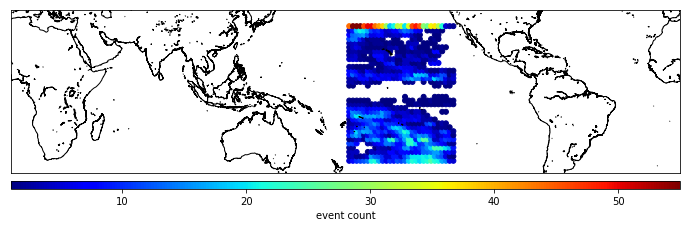

In [5]:
bbox = [-40,40,0,360]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines
m.drawcoastlines()

Lat_Boxes = range(-35,35,2)
Lon_Boxes = range(-180,-120,2)

llat, llon = np.meshgrid(Lat_Boxes,Lon_Boxes)
llat = llat.flatten()
llon = llon.flatten()

events_count = np.zeros((len(llat)))

for i in range(n_clusters_):
    cluster = Data[labels==i,:]
    cluster = np.unique(cluster[:,1:3],axis=0)
    incluster = np.zeros(len(llat))
    for j in range(len(cluster)):
        ind_near = find_nearest_box(llat,llon,cluster[j,:])
        incluster[ind_near] = 1
    events_count += incluster


llat = llat[events_count!=0]
llon = llon[events_count!=0]
events_count = events_count[events_count!=0]

cs = m.scatter(llon.flatten(),llat.flatten(), latlon=True, c=events_count.flatten(), s=25,cmap='jet')
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('event count')


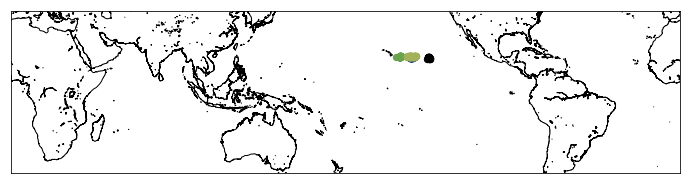

In [16]:
#region overwhich to show the plot
bbox = [-40,40,0,360]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()

#look at the clusters within the range labels_min to labels_max
labels_min = np.min(labels)+1150
labels_max = 1155

#plot the location of rain for the individual clusters (colored by cluster)
for ii in range(labels_min,labels_max):
    cluster = Data[labels==ii,:]
    color_interp = np.interp(ii,[labels_min,labels_max],[0,200])
    m.scatter(cluster[:,2],cluster[:,1],s=40,marker='o',color=cmap(int(color_interp)),latlon=True)

In [19]:
print((Data[10,:]))

[ 1.11490528e+03 -3.60999985e+01 -1.23050003e+02  6.78152990e+00
 -9.22524989e-01 -1.56068996e-01  1.69885600e+00  3.75840306e+00
  5.71217108e+00  5.15935993e+00  1.17595398e+00  2.20716000e-01
  1.32361993e-01  5.73830009e-02  3.88289988e-02  2.60150004e-02
  1.18060000e-02  4.65099979e-03  6.36200001e-03  6.03799988e-03
  1.61299994e-03  0.00000000e+00  0.00000000e+00]


In [43]:
import datetime
test = Time[0]
TI = pd.DatetimeIndex(Time)
print(TI[0].month)

1
